<a href="https://colab.research.google.com/github/ffaghri1/ALS-ML/blob/main/ALS_subtype_identification_short_summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ALS subtype identification 

Faraz Faghri

Last update: Jul 22, 2021

Goal: describing clusters (subtypes) of ALS based on clinical and genetic observations.

## Prepare the notebook environment

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid",{'axes.grid': False})
sns.set_palette('Set1')
import random
random.seed(42)  # set program wide random seed
from tensorflow import set_random_seed
set_random_seed(42)

# Adapt pandas view for large datasets
#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Data load 

**Goal:** Load data. Removing bias, skewness, and dealing with missingness.

In [ ]:
# Read in Adriano data
# df_raw = pd.read_csv("../data/Freeze5/scriptToWrangleJessicaDataFreeze5/ALSregistry.AdrianoChio.wrangled.nodates.freeze5.csv", na_values=[""," ","NA"])
df_raw = pd.read_csv("/content/drive/My Drive/Projects/2018-08-23 ALS clustering/data/Freeze5/scriptToWrangleJessicaDataFreeze5/ALSregistry.AdrianoChio.wrangled.nodates.freeze5.csv", na_values=[""," ","NA"], index_col='number')

# Read in Jessican data (replication)
# df_raw_rep = pd.read_csv("../data/Freeze5/scriptToWrangleJessicaDataFreeze5/ALSregistry.JessicaMandrioli.wrangled.nodates.freeze5.csv")
df_raw_rep = pd.read_csv("/content/drive/My Drive/Projects/2018-08-23 ALS clustering/data/Freeze5/scriptToWrangleJessicaDataFreeze5/ALSregistry.JessicaMandrioli.wrangled.nodates.freeze5.csv", na_values=[""," ","NA"], index_col='number')

In [ ]:
# Adriano data size
df_raw.shape

(2858, 72)

In [ ]:
# Jessica data size
df_raw_rep.shape

(1097, 72)

In [ ]:
# check if Adriano and Jessica data have same exact features. answer: yes
colnames_rep = df_raw_rep.columns.values.tolist()
colnames_org = df_raw.columns.values.tolist()

list(set(colnames_rep) - set(colnames_org))

[]

In [ ]:
df_raw.index

Int64Index([ 772,  593,  550, 2652, 2334, 2401, 1165,  667, 2612, 1360,
            ...
            2637, 2639, 2641, 2669, 2673, 2683, 2684, 2704, 2773, 2791], dtype='int64', name='number', length=2858)

## Data exploration
**Goal:** Do we observe any particular class imbalances or patterns?

**Result:** We did not.

### Visualize selected features

#### Gender

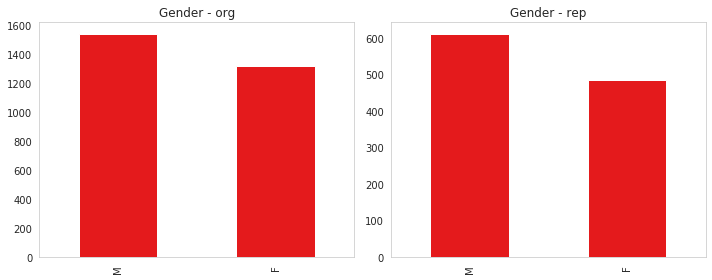

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns
ax1 = df_raw.sex.value_counts().plot(kind='bar', ax=ax1)
ax1.set_title('Gender - org')
ax2 = df_raw_rep.sex.value_counts().plot(kind='bar', ax=ax2)
ax2.set_title('Gender - rep')
plt.tight_layout()  

#### Site of the first occurrence of ALS


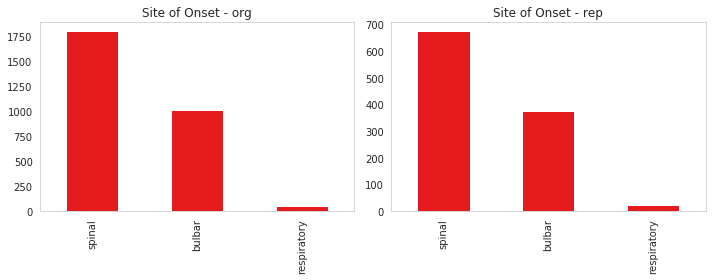

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns
ax1 = df_raw.site_of_onset.value_counts().plot(kind='bar', ax=ax1)
ax1.set_title('Site of Onset - org')
ax2 = df_raw_rep.site_of_onset.value_counts().plot(kind='bar', ax=ax2)
ax2.set_title('Site of Onset - rep')
plt.tight_layout()  

#### ALS Subtypes

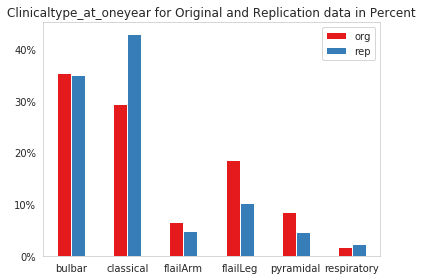

In [ ]:
from matplotlib.ticker import FuncFormatter

clinic_temp_org = df_raw.clinicaltype_at_oneyear.value_counts() / (sum(df_raw.clinicaltype_at_oneyear.value_counts()))
clinic_temp_org.rename('org', inplace=True)

clinic_temp_rep = df_raw_rep.clinicaltype_at_oneyear.value_counts() / (sum(df_raw_rep.clinicaltype_at_oneyear.value_counts()))
clinic_temp_rep.rename('rep', inplace=True)

df_clinicdeath_combine = pd.concat([clinic_temp_org, clinic_temp_rep], axis=1, sort=True)
ax = df_clinicdeath_combine.plot.bar(rot=0, grid=False)

ax.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
ax.set_title('Clinicaltype_at_oneyear for Original and Replication data in Percent')
plt.tight_layout()

Here we can see a difference in the distribution of the *clinicaltype_at_oneyear* feature. Jessica's data has fewer patients with flailLeg type percent-wise compared to Adriano's, but a lot more classical onset! 

**IDEA:** maybe it is geo-related? Combine both data and check the distribution for each location.

## Data Cleaning

### Plot heatmap of missing values

**Goal:** Identify patterns of data missing. Decide whether to remove or impute those rows or columns.

**Results:**

Text(0.5, 1, 'Missing values heatmap - org data, black is NaN')

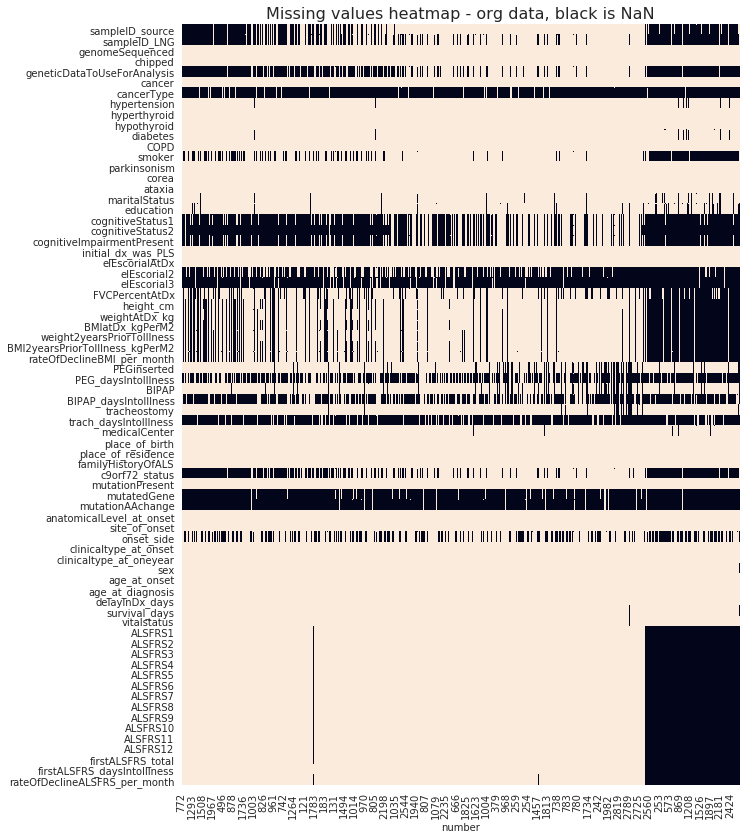

In [ ]:
# Create binary map and plot as heatmap
df_heatmap = df_raw.copy().notnull().astype(int)
fig, ax = plt.subplots(figsize=(10,14))   
sns.heatmap(df_heatmap.transpose(), ax=ax, cbar=False).set_title('Missing values heatmap - org data, black is NaN',fontsize=16)

Text(0.5, 1, 'Missing values heatmap - rep data, black is NaN')

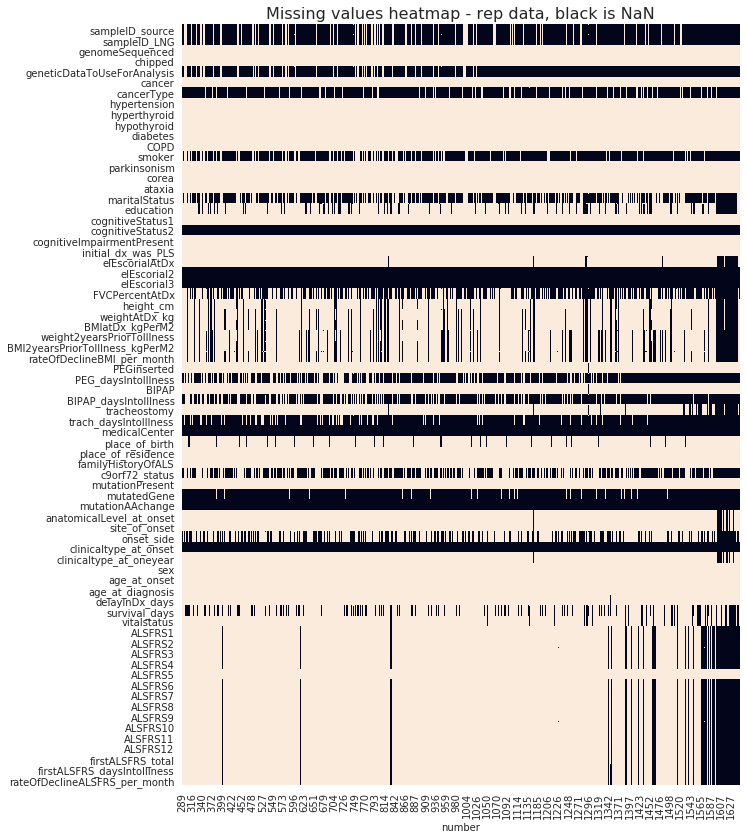

In [ ]:
# Heatmap for replicaiton data
df_heatmap_rep = df_raw_rep.copy().notnull().astype(int)
fig, ax = plt.subplots(figsize=(10,14))   
sns.heatmap(df_heatmap_rep.transpose(), ax=ax, cbar=False).set_title('Missing values heatmap - rep data, black is NaN',fontsize=16)

### Dropping certain features 

due to irrelevance, skewness, or data leakage

In [ ]:
features_to_omit = ['sampleID_source', 'sampleID_LNG', 'genomeSequenced', 
                    'chipped', 'geneticDataToUseForAnalysis', 'medicalCenter', 
                    'place_of_birth', 'place_of_residence', 'cancerType', 
                    'elEscorial2', 'elEscorial3', 'PEGinserted', 'PEG_daysIntoIllness', 
                    'BIPAP', 'BIPAP_daysIntoIllness', 'tracheostomy', 
                    'trach_daysIntoIllness', 'survival_days', 'vitalstatus', 'c9orf72_status', 
                    'initial_dx_was_PLS', 'mutationPresent', 'mutatedGene', 
                    'mutationAAchange', 'smoker', 'cognitiveStatus1', 
                    'cognitiveStatus2', 'cognitiveImpairmentPresent', 
                    'clinicaltype_at_onset']
df_omitted = df_raw.drop(columns=features_to_omit)
df_omitted_rep = df_raw_rep.drop(columns=features_to_omit)


list(set(df_omitted.columns.values.tolist()) - set(df_omitted_rep.columns.values.tolist()))

[]

Text(0.5, 1, 'Missing values heatmap - rep data, black is NaN')

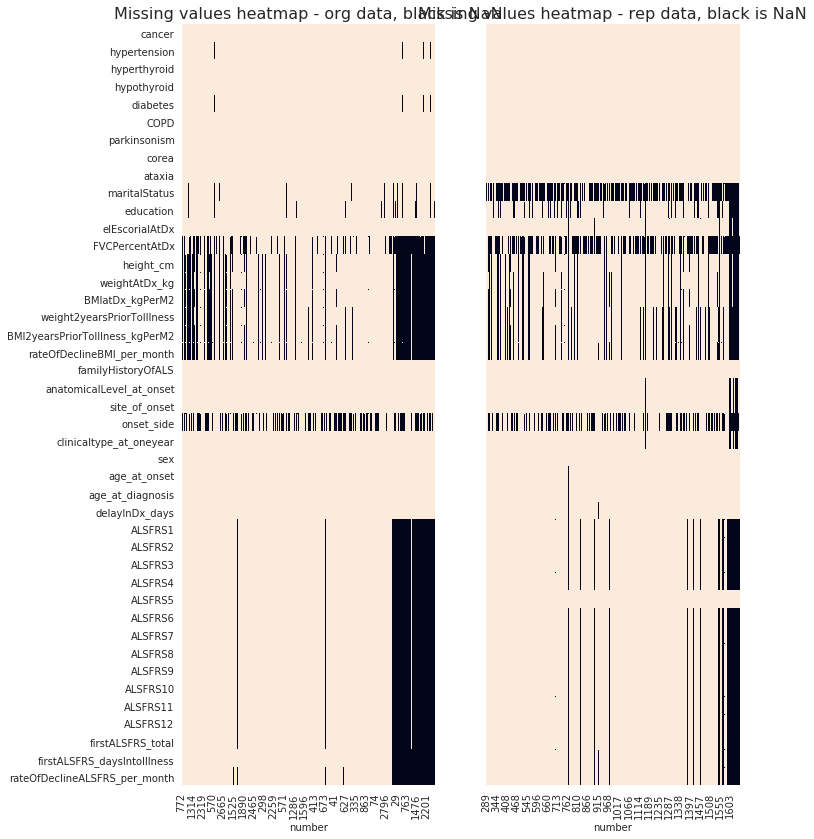

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True,figsize=(10,14))

# Create binary map and plot as heatmap
df_heatmap = df_omitted.copy().notnull().astype(int)
sns.heatmap(df_heatmap.transpose(), ax=ax1, cbar=False).set_title('Missing values heatmap - org data, black is NaN',fontsize=16)

# Heatmap for replicaiton data
df_heatmap_rep = df_omitted_rep.copy().notnull().astype(int)
sns.heatmap(df_heatmap_rep.transpose(), ax=ax2, cbar=False).set_title('Missing values heatmap - rep data, black is NaN',fontsize=16)


### Dropping certain samples with missing values

In [ ]:
list_na_features = ['ALSFRS1', 'ALSFRS2', 'ALSFRS3', 'ALSFRS4', 'ALSFRS5', 'ALSFRS6', 
                        'ALSFRS7', 'ALSFRS8', 'ALSFRS9', 'ALSFRS10', 'ALSFRS11', 'ALSFRS12', 
                        'firstALSFRS_total', 'firstALSFRS_daysIntoIllness', 
                    'rateOfDeclineALSFRS_per_month', 'hypertension', 'hypertension', 
                    'sex', 'clinicaltype_at_oneyear']

df_omitted = df_omitted.dropna(subset=list_na_features)
df_omitted_rep = df_omitted_rep.dropna(subset=list_na_features)

Text(0.5, 1, 'Missing values heatmap - rep data, black is NaN')

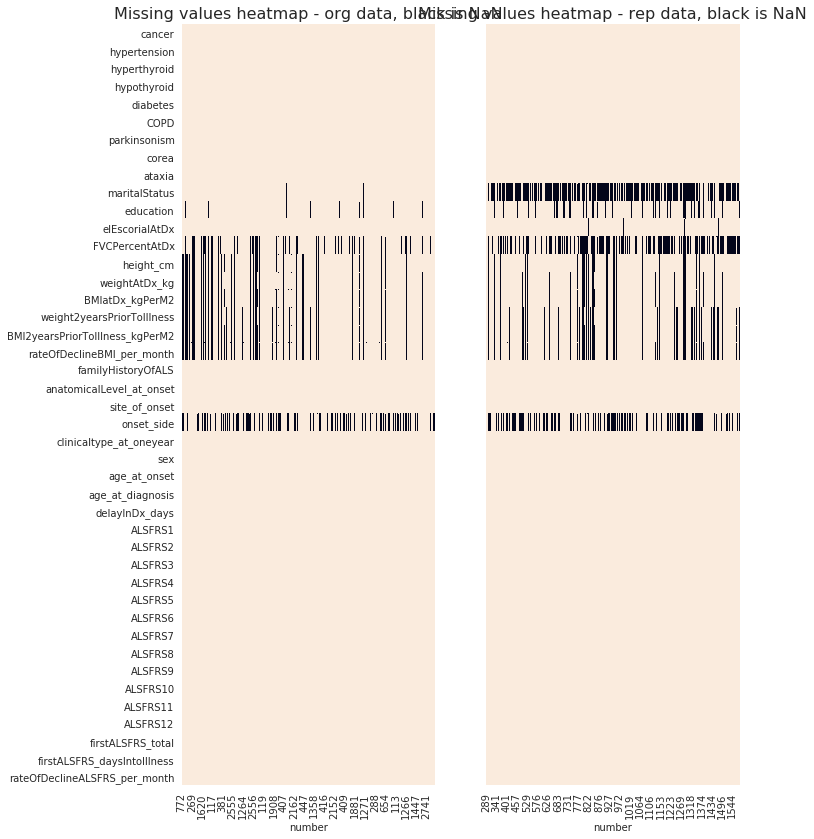

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True,figsize=(10,14))

# Create binary map and plot as heatmap
df_heatmap = df_omitted.copy().notnull().astype(int)
sns.heatmap(df_heatmap.transpose(), ax=ax1, cbar=False).set_title('Missing values heatmap - org data, black is NaN',fontsize=16)

# Heatmap for replicaiton data
df_heatmap_rep = df_omitted_rep.copy().notnull().astype(int)
sns.heatmap(df_heatmap_rep.transpose(), ax=ax2, cbar=False).set_title('Missing values heatmap - rep data, black is NaN',fontsize=16)


### Dropping the main label 'clinicaltype_at_oneyear'

In [ ]:
df_omitted = df_omitted.drop(columns='clinicaltype_at_oneyear')
df_omitted_rep = df_omitted_rep.drop(columns='clinicaltype_at_oneyear')

### Fill onset_site with 'bulbar'

In [ ]:
df_omitted.onset_side.unique()

array(['left', nan, 'right', 'both'], dtype=object)

In [ ]:
# ORG data
idx_siteonset_bulbar = df_omitted.site_of_onset.index[df_omitted.site_of_onset == 'bulbar'].tolist()
idx_siteonset_respiratory = df_omitted.site_of_onset.index[df_omitted.site_of_onset == 'respiratory'].tolist()

df_omitted.onset_side.loc[idx_siteonset_bulbar] = 'bulbar'
df_omitted.onset_side.loc[idx_siteonset_respiratory] = 'respiratory'

# REP data
idx_siteonset_bulbar = df_omitted_rep.site_of_onset.index[df_omitted_rep.site_of_onset == 'bulbar'].tolist()
idx_siteonset_respiratory = df_omitted_rep.site_of_onset.index[df_omitted_rep.site_of_onset == 'respiratory'].tolist()

df_omitted_rep.onset_side.loc[idx_siteonset_bulbar] = 'bulbar'
df_omitted_rep.onset_side.loc[idx_siteonset_respiratory] = 'respiratory'

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Text(0.5, 1, 'Missing values heatmap - rep data, black is NaN')

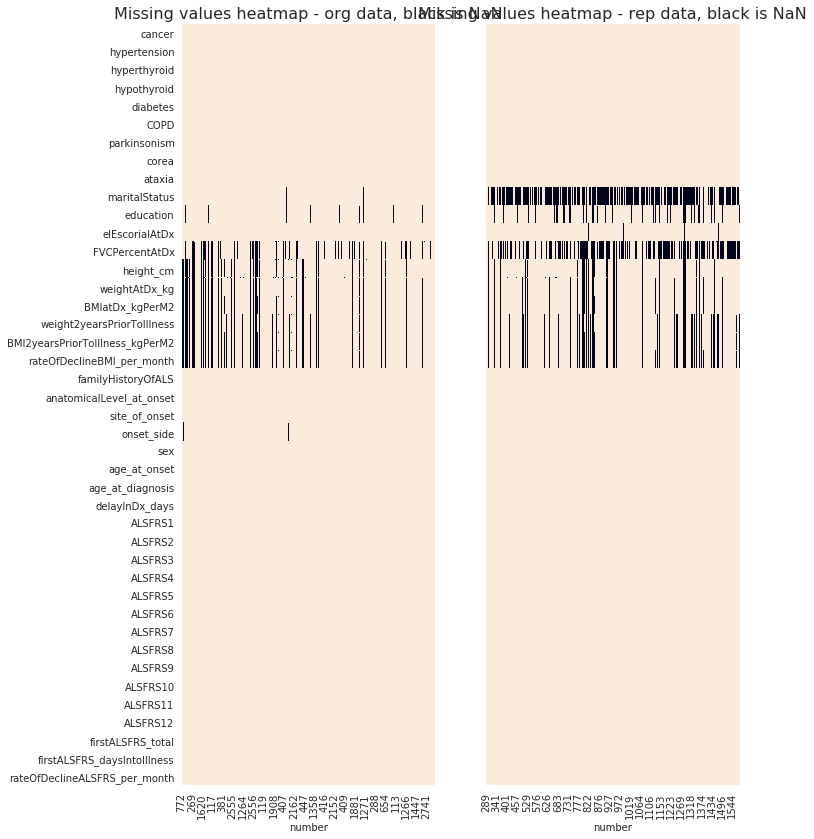

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True,figsize=(10,14))

# Create binary map and plot as heatmap
df_heatmap = df_omitted.copy().notnull().astype(int)
sns.heatmap(df_heatmap.transpose(), ax=ax1, cbar=False).set_title('Missing values heatmap - org data, black is NaN',fontsize=16)

# Heatmap for replicaiton data
df_heatmap_rep = df_omitted_rep.copy().notnull().astype(int)
sns.heatmap(df_heatmap_rep.transpose(), ax=ax2, cbar=False).set_title('Missing values heatmap - rep data, black is NaN',fontsize=16)


### Normalization 

#### min-max numerical features

In [ ]:
# The scipy method is not used, as it cannot handle NaNs
features_to_normalize = ['height_cm', 'weightAtDx_kg', 'BMIatDx_kgPerM2', 'FVCPercentAtDx',
                         'weight2yearsPriorToIllness', 'BMI2yearsPriorToIllness_kgPerM2',
                         'rateOfDeclineBMI_per_month',
                         'age_at_onset', 'age_at_diagnosis',
                         'delayInDx_days', 'firstALSFRS_daysIntoIllness',
                         'rateOfDeclineALSFRS_per_month', 'ALSFRS1', 'ALSFRS2', 'ALSFRS3', 'ALSFRS4', 'ALSFRS5',
                         'ALSFRS6', 'ALSFRS7', 'ALSFRS8', 'ALSFRS9', 'ALSFRS10', 'ALSFRS11', 'ALSFRS12', 'firstALSFRS_total']

df_numfeat_normalized = df_omitted[features_to_normalize].apply(lambda x: (x - np.min(x, axis=0)) / (np.max(x, axis=0) - np.min(x, axis=0)))
df_numfeat_normalized_rep = df_omitted_rep[features_to_normalize].apply(lambda x: (x - np.min(x, axis=0)) / (np.max(x, axis=0) - np.min(x, axis=0)))


#### 1-Hot encoding categorical features

In [ ]:
# Get list of categorical features
all_feature_names = list(df_omitted)
categorical_features = list(set(all_feature_names).symmetric_difference(set(features_to_normalize)))

# ORG
df_dummyvars = pd.get_dummies(df_omitted[categorical_features])
df_1hot = pd.concat([df_numfeat_normalized, df_dummyvars], axis=1)

# REP
df_dummyvars_rep = pd.get_dummies(df_omitted_rep[categorical_features])
df_1hot_rep = pd.concat([df_numfeat_normalized_rep, df_dummyvars_rep], axis=1)


### Impute values using Multiple Imputation

In [ ]:
columns = df_1hot.columns
percent_missing = df_1hot.isnull().sum() * 100 / len(df_1hot)
percent_missing.sort_values(ascending=False)#[percent_missing > 0]

FVCPercentAtDx                                   20.203304
BMI2yearsPriorToIllness_kgPerM2                  18.424396
rateOfDeclineBMI_per_month                       18.424396
weight2yearsPriorToIllness                       17.196103
BMIatDx_kgPerM2                                  16.603134
height_cm                                        16.179585
weightAtDx_kg                                    14.908937
sex_M                                             0.000000
firstALSFRS_total                                 0.000000
firstALSFRS_daysIntoIllness                       0.000000
rateOfDeclineALSFRS_per_month                     0.000000
COPD_no                                           0.000000
COPD_yes                                          0.000000
sex_F                                             0.000000
site_of_onset_spinal                              0.000000
site_of_onset_bulbar                              0.000000
site_of_onset_respiratory                         0.0000

In [ ]:
import fancyimpute

train_cols = list(df_1hot)
df_1hot_imp = pd.DataFrame(fancyimpute.KNN(k=5).fit_transform(df_1hot), index=df_1hot.index)
df_1hot_imp.columns = train_cols

train_cols_rep = list(df_1hot_rep)
df_1hot_imp_rep = pd.DataFrame(fancyimpute.KNN(k=5).fit_transform(df_1hot_rep), index=df_1hot_rep.index)
df_1hot_imp_rep.columns = train_cols_rep


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
Using TensorFlow backend.


Imputing row 1/2361 with 0 missing, elapsed time: 2.503
Imputing row 101/2361 with 0 missing, elapsed time: 2.512
Imputing row 201/2361 with 0 missing, elapsed time: 2.521
Imputing row 301/2361 with 0 missing, elapsed time: 2.530
Imputing row 401/2361 with 0 missing, elapsed time: 2.536
Imputing row 501/2361 with 0 missing, elapsed time: 2.542
Imputing row 601/2361 with 7 missing, elapsed time: 2.548
Imputing row 701/2361 with 0 missing, elapsed time: 2.553
Imputing row 801/2361 with 7 missing, elapsed time: 2.558
Imputing row 901/2361 with 0 missing, elapsed time: 2.563
Imputing row 1001/2361 with 0 missing, elapsed time: 2.568
Imputing row 1101/2361 with 6 missing, elapsed time: 2.571
Imputing row 1201/2361 with 7 missing, elapsed time: 2.575
Imputing row 1301/2361 with 1 missing, elapsed time: 2.578
Imputing row 1401/2361 with 0 missing, elapsed time: 2.579
Imputing row 1501/2361 with 0 missing, elapsed time: 2.581
Imputing row 1601/2361 with 0 missing, elapsed time: 2.584
Imputing 

In [ ]:
df_1hot_imp.columns

Index(['height_cm', 'weightAtDx_kg', 'BMIatDx_kgPerM2', 'FVCPercentAtDx', 'weight2yearsPriorToIllness', 'BMI2yearsPriorToIllness_kgPerM2', 'rateOfDeclineBMI_per_month', 'age_at_onset', 'age_at_diagnosis', 'delayInDx_days', 'firstALSFRS_daysIntoIllness', 'rateOfDeclineALSFRS_per_month', 'ALSFRS1', 'ALSFRS2', 'ALSFRS3', 'ALSFRS4', 'ALSFRS5', 'ALSFRS6', 'ALSFRS7', 'ALSFRS8', 'ALSFRS9', 'ALSFRS10', 'ALSFRS11', 'ALSFRS12', 'firstALSFRS_total', 'firstALSFRS_daysIntoIllness', 'rateOfDeclineALSFRS_per_month', 'COPD_no', 'COPD_yes', 'sex_F', 'sex_M', 'site_of_onset_bulbar', 'site_of_onset_respiratory', 'site_of_onset_spinal', 'ataxia_no', 'ataxia_yes', 'diabetes_no', 'diabetes_yes', 'education_11years', 'education_13years', 'education_18years', 'education_5years', 'education_8years', 'education_lessthan5years', 'corea_no', 'corea_yes', 'hypothyroid_no', 'hypothyroid_yes', 'hyperthyroid_no', 'hyperthyroid_yes', 'anatomicalLevel_at_onset_bulbar', 'anatomicalLevel_at_onset_lower_limbs_distal',
   

Text(0.5, 1, 'Missing values heatmap - rep data, black is NaN')

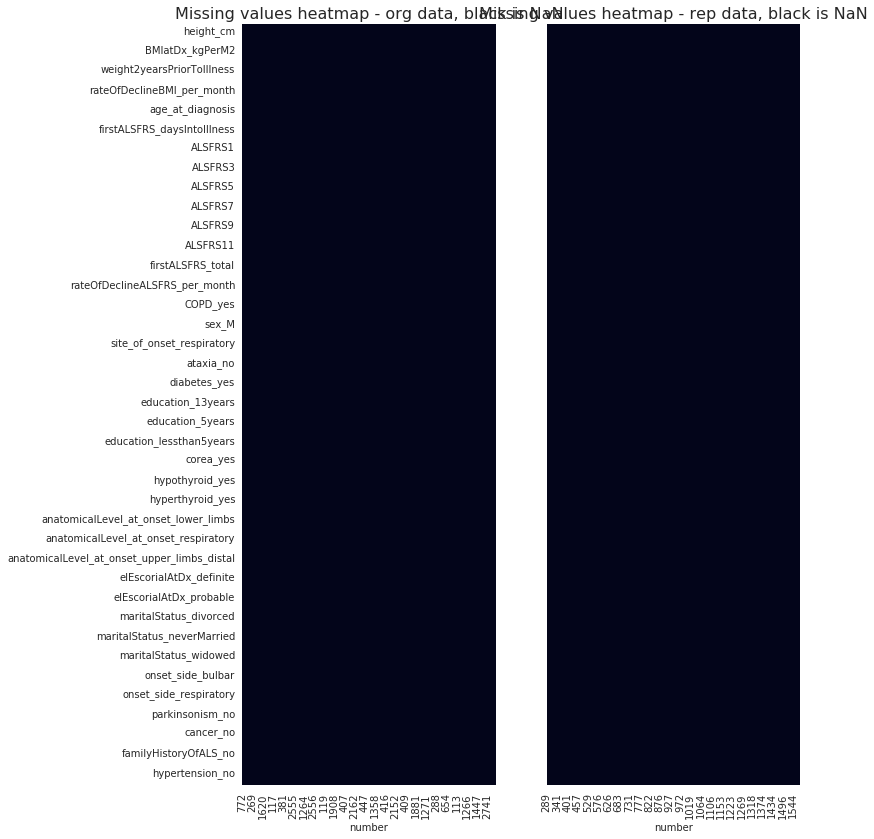

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True,figsize=(10,14))

# Create binary map and plot as heatmap
df_heatmap = df_1hot_imp.copy().notnull().astype(int)
sns.heatmap(df_heatmap.transpose(), ax=ax1, cbar=False).set_title('Missing values heatmap - org data, black is NaN',fontsize=16)

# Heatmap for replicaiton data
df_heatmap_rep = df_1hot_imp_rep.copy().notnull().astype(int)
sns.heatmap(df_heatmap_rep.transpose(), ax=ax2, cbar=False).set_title('Missing values heatmap - rep data, black is NaN',fontsize=16)


### Export data

In [ ]:
# columns to include with umap
coloring_columns_raw =['clinicaltype_at_oneyear']

# export df_1hot_imp
df_1hot_imp_color = pd.concat([df_raw[coloring_columns_raw], df_1hot_imp], axis=1, join='inner')
# df_1hot_imp_color.drop(columns="number", inplace=True)
df_1hot_imp_color.to_csv(r'ALS_df_1hot_imp_org.csv', na_rep='NA',sep='\t')

# export df_1hot_imp_rep
df_1hot_imp_rep_color = pd.concat([df_raw[coloring_columns_raw], df_1hot_imp_rep], axis=1, join='inner')
# df_1hot_imp_rep_color.drop(columns="number", inplace=True)
df_1hot_imp_rep_color.to_csv(r'ALS_df_1hot_imp_rep.csv', na_rep='NA',sep='\t')


## ALS unsupervised clustering

### UMAP Analysis

In [ ]:
# Setting up DF for the Isomap
res_umap_columns = ['UMAP_2_1', 'UMAP_2_2']  # 'Isomap_3_1', 'Isomap_3_2', 'Isomap_3_3'
res_umap = pd.DataFrame(index=df_1hot_imp.index, columns=res_umap_columns)
res_umap_rep = pd.DataFrame(index=df_1hot_imp_rep.index, columns=res_umap_columns)

In [ ]:
# Perform UMAP 2D
from umap import UMAP
model_umap= UMAP(n_neighbors=15,
                 min_dist=1,
                 n_components=2,
                 metric='euclidean')

model_umap_rep = UMAP(n_neighbors=15,
                      min_dist=1,
                      n_components=2,
                      metric='euclidean')

# Fit model
res_umap[['UMAP_2_1', 'UMAP_2_2']] = model_umap.fit_transform(df_1hot_imp)
res_umap_rep[['UMAP_2_1', 'UMAP_2_2']] = model_umap_rep.fit_transform(df_1hot_imp_rep)

In [ ]:
df_raw.sort_index().index

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            2915, 2923, 2924, 2925, 2926, 2931, 2946, 2954, 2968, 2970], dtype='int64', name='number', length=2858)

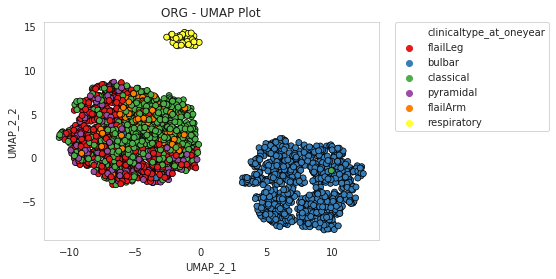

In [ ]:
%matplotlib inline
sns.scatterplot(x=res_umap.UMAP_2_1, y=res_umap.UMAP_2_2, data=df_raw, hue='clinicaltype_at_oneyear',
                hue_order = ['flailLeg','bulbar','classical','pyramidal','flailArm','respiratory'],
                edgecolor='k').set_title('ORG - UMAP Plot')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

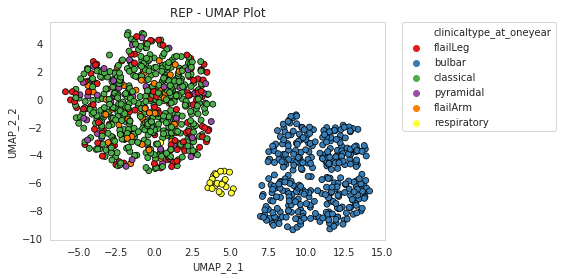

In [ ]:
%matplotlib inline
sns.scatterplot(x=res_umap_rep.UMAP_2_1, y=res_umap_rep.UMAP_2_2, data=df_raw_rep, hue='clinicaltype_at_oneyear',
                hue_order = ['flailLeg','bulbar','classical','pyramidal','flailArm','respiratory'],
                edgecolor='k').set_title('REP - UMAP Plot')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### UMAP Analysis 3D

In [ ]:
# Setting up DF for the Isomap
res_umap3d_columns = ['UMAP_3_1', 'UMAP_3_2', 'UMAP_3_3']  # 'Isomap_3_1', 'Isomap_3_2', 'Isomap_3_3'
res_umap3d = pd.DataFrame(index=df_1hot_imp.index, columns=res_umap3d_columns)
res_umap3d_rep = pd.DataFrame(index=df_1hot_imp_rep.index, columns=res_umap3d_columns)

In [ ]:
# Perform UMAP 3D
from umap import UMAP
model_umap3d= UMAP(n_neighbors=15,
                 min_dist=1,
                 n_components=3,
                 metric='euclidean')

model_umap3d_rep = UMAP(n_neighbors=15,
                      min_dist=1,
                      n_components=3,
                      metric='euclidean')

# Fit model
res_umap3d[['UMAP_3_1', 'UMAP_3_2', 'UMAP_3_3']] = model_umap3d.fit_transform(df_1hot_imp)
res_umap3d_rep[['UMAP_3_1', 'UMAP_3_2', 'UMAP_3_3']] = model_umap3d_rep.fit_transform(df_1hot_imp_rep)

In [ ]:
# 3D plot
from mpl_toolkits.mplot3d import Axes3D

res_umap3d_labeled = pd.concat([res_umap3d, df_raw.clinicaltype_at_oneyear], axis=1, join='inner')

import plotly.express as px
fig = px.scatter_3d(res_umap3d_labeled, x='UMAP_3_1', y='UMAP_3_2', z='UMAP_3_3',
                    color='clinicaltype_at_oneyear')
fig.show()


In [ ]:
# 3D plot
from mpl_toolkits.mplot3d import Axes3D

res_umap3d_rep_labeled = pd.concat([res_umap3d_rep, df_raw_rep.clinicaltype_at_oneyear], axis=1, join='inner')

import plotly.express as px
fig = px.scatter_3d(res_umap3d_rep_labeled, x='UMAP_3_1', y='UMAP_3_2', z='UMAP_3_3',
                    color='clinicaltype_at_oneyear')
fig.show()


### Export data

In [ ]:
# columns to include with umap
coloring_columns =['clinicaltype_at_oneyear', 'smoker', 'initial_dx_was_PLS', 'c9orf72_status', 
        'mutationPresent', 'mutatedGene', 'mutationAAchange', 'cognitiveStatus1', 
        'cognitiveStatus2', 'cognitiveImpairmentPresent', 'clinicaltype_at_onset', 
        'PEGinserted', 'PEG_daysIntoIllness', 'BIPAP', 'BIPAP_daysIntoIllness', 
        'elEscorial2', 'elEscorial3', 'age_at_onset', 'sex', 'rateOfDeclineALSFRS_per_month']

# export 2D ORG csv
df_color = pd.concat([res_umap, df_raw[coloring_columns]], axis=1, join='inner')
df_color.to_csv(r'ALS_umap2d_org.csv', na_rep='NA')

# export 2D REP csv
res_umap_rep['UMAP_2_2'] = -res_umap_rep['UMAP_2_2'] # flip the Y axes for asthetics 
df_color = pd.concat([res_umap_rep, df_raw_rep[coloring_columns]], axis=1, join='inner')
df_color.to_csv(r'ALS_umap2d_rep.csv', na_rep='NA')

# export 3D ORG csv
df_color = pd.concat([res_umap3d, df_raw[coloring_columns]], axis=1, join='inner')
df_color.to_csv(r'ALS_umap3d_org.csv', na_rep='NA')

# export 3D REP csv
df_color_rep = pd.concat([res_umap3d_rep, df_raw_rep[coloring_columns]], axis=1, join='inner')
df_color_rep.to_csv(r'ALS_umap3d_rep.csv', na_rep='NA')

## ALS semi-supervised clustering

### Prepare data

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neural_network._base import ACTIVATIONS

# Original data. set X=data, y=label: 'clinicaltype_at_death'
# join to make sure index are sorted and matched
df_1hot_imp_labeled = pd.concat([df_1hot_imp, df_raw['clinicaltype_at_oneyear']], axis=1, join='inner') 

X = df_1hot_imp_labeled.loc[:, df_1hot_imp_labeled.columns != 'clinicaltype_at_oneyear']
y = df_1hot_imp_labeled[['clinicaltype_at_oneyear']]

# Replication data. X_rep and y_rep
df_1hot_imp_rep_labeled = pd.concat([df_1hot_imp_rep, df_raw_rep['clinicaltype_at_oneyear']], axis=1, join='inner') 

X_rep = df_1hot_imp_rep_labeled.loc[:, df_1hot_imp_rep_labeled.columns != 'clinicaltype_at_oneyear']
y_rep = df_1hot_imp_rep_labeled[['clinicaltype_at_oneyear']]

### Original data 

#### Train the neural network and k-fold cross validation

In [ ]:
from sklearn.model_selection import KFold

# if train-validate-test split wanted:
# X_CV, X_test, y_CV, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=42)
X_CV = X
y_CV = y

# array with possible alphas to test
# alphas = np.logspace(-8, -5, num=7)
alphas = [1.00e-05]#[2e-5] # best perfoming one from previous line 
rand_state = 3 #3

# set number of folds and initialise sklearn KFold
K = 10
kf = KFold(n_splits=K, shuffle=True, random_state=rand_state)

val_best_nn = 0

for alpha in alphas:

    
    # initialize Neural Network
    nn = MLPClassifier(hidden_layer_sizes=(200,100,50,25,3), max_iter=500, alpha=alpha, solver='adam',
                       verbose=False, random_state=rand_state, activation='relu')

    # Start with k-fold cross validation
    class_scores_train = []
    class_scores_val = []
    
    for train_index, val_index in kf.split(X_CV, y_CV):

        # set up Neural Network
        nn.fit(X_CV.iloc[train_index], y_CV.iloc[train_index].values.ravel())  # ravel flattens the array from (X, 1) to (X, )

        # predict y_train, y_val
        predictions_train = nn.predict(X_CV.iloc[train_index])
        predictions_val = nn.predict(X_CV.iloc[val_index])

        # append accuracy to appropriate list
        class_scores_train.append(accuracy_score(y_CV.iloc[train_index],predictions_train))
        class_scores_val.append(accuracy_score(y_CV.iloc[val_index],predictions_val))
    
    if np.mean(class_scores_val) > val_best_nn:
        val_best_nn = np.mean(class_scores_val)
        best_nn = nn
    
    print('alpha: {:.2e} | mean(train_acc): {:.2f} | mean(val_acc): {:.2f}'.
          format(alpha,
                 round(np.mean(class_scores_train),4),
                 round(np.mean(class_scores_val),4)))


alpha: 1.00e-05 | mean(train_acc): 0.82 | mean(val_acc): 0.74


#### Forward pass to get activations of best approach

In [ ]:
# Rebuild forward loop to get output of last hidden layer
out_layer = ACTIVATIONS['relu'](np.matmul(X.values, best_nn.coefs_[0]) + best_nn.intercepts_[0])

# Forward pass through layers up until the 2 last. Last is for classification, 2nd-to-last we do not want the activation
no_layers = len(best_nn.intercepts_)-1
for i in range(1,no_layers-1): 
    out_layer = ACTIVATIONS['relu'](np.matmul(out_layer, best_nn.coefs_[i]) + best_nn.intercepts_[i])

out_layer_3outputs = np.matmul(out_layer, best_nn.coefs_[no_layers-1]) + best_nn.intercepts_[no_layers-1]

df_nnout = pd.DataFrame(out_layer_3outputs, index=df_1hot_imp.index, columns=['Dim_1', 'Dim_2', 'Dim_3'])

#### Plotting of NN activations with 'clinicaltype_at_oneyear' highlighted

In [ ]:
# 3D plot
df_nnout_labeled = pd.concat([df_nnout, df_raw.clinicaltype_at_oneyear], axis=1, join='inner')

import plotly.express as px
fig = px.scatter_3d(df_nnout_labeled, x='Dim_1', y='Dim_2', z='Dim_3',
                    color='clinicaltype_at_oneyear')
fig.show()


#### t-SNE 2D

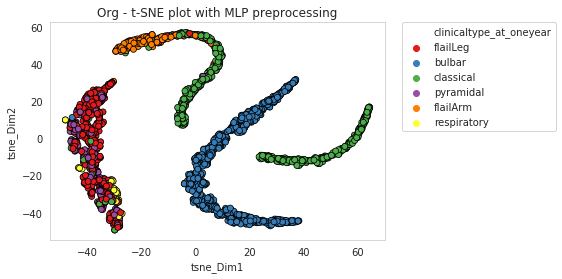

In [ ]:
from sklearn.manifold import TSNE as sklearnTSNE
# Calculate the 2D tSNE and transform it to a Dataframe
res_tsne_2D = sklearnTSNE(n_components=2, perplexity=35, random_state=2).fit_transform(df_nnout)

df_resTSNE_2D = pd.DataFrame(res_tsne_2D, columns=['tsne_Dim1', 'tsne_Dim2'], index=df_1hot_imp.index)

# Plot the 2D t-SNE plot
%matplotlib inline
sns.set_palette('Set1')
sns.scatterplot(x=df_resTSNE_2D.tsne_Dim1, y=df_resTSNE_2D.tsne_Dim2, data=df_raw, hue='clinicaltype_at_oneyear',
               edgecolor='k').set_title('Org - t-SNE plot with MLP preprocessing')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


#### t-SNE 3D

In [ ]:
res_tsne = sklearnTSNE(n_components=3, perplexity=20, random_state=42).fit_transform(df_nnout)
df_resTSNE = pd.DataFrame(res_tsne, columns=['tsne_Dim1', 'tsne_Dim2', 'tsne_Dim3'], index=df_1hot_imp.index)

# 3D plot
df_resTSNE_labeled = pd.concat([df_resTSNE, df_raw.clinicaltype_at_oneyear], axis=1, join='inner')

import plotly.express as px
fig = px.scatter_3d(df_resTSNE_labeled, x='tsne_Dim1', y='tsne_Dim2', z='tsne_Dim3',
                    color='clinicaltype_at_oneyear')
fig.show()


#### UMAP

In [ ]:
# Perform UMAP 3D
res_umap3d_columns = ['UMAP_3_1', 'UMAP_3_2', 'UMAP_3_3'] 
res_df_nnout_umap3d = pd.DataFrame(index=df_1hot_imp.index, columns=res_umap3d_columns)

from umap import UMAP
model_umap3d= UMAP(n_neighbors=15,
                 min_dist=1,
                 n_components=3,
                 metric='euclidean')

# Fit model
res_df_nnout_umap3d[['UMAP_3_1', 'UMAP_3_2', 'UMAP_3_3']] = model_umap3d.fit_transform(df_nnout)

# 3D plot
res_df_nnout_umap3d_labeled = pd.concat([res_df_nnout_umap3d, df_raw.clinicaltype_at_oneyear], axis=1, join='inner')

import plotly.express as px
fig = px.scatter_3d(res_df_nnout_umap3d_labeled, x='UMAP_3_1', y='UMAP_3_2', z='UMAP_3_3',
                    color='clinicaltype_at_oneyear')
fig.show()


/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 2 separate connected components using meta-embedding (experimental)



### Replication data

#### Train the neural network and k-fold cross validation

In [ ]:
from sklearn.model_selection import KFold

# if train-validate-test split wanted:
# X_CV, X_test, y_CV, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=42)
X_CV = X_rep
y_CV = y_rep

# array with possible alphas to test
# alphas = np.logspace(-8, -2, num=13)
# print(alphas)
alphas = [1.00e-03]#[2e-4] #best performing one from previous line 
rand_state = 2

# set number of folds and initialise sklearn KFold
K = 10
kf = KFold(n_splits=K, shuffle=True, random_state=rand_state)

val_best_nn = 0

for alpha in alphas:

    
    # initialize Neural Network
    nn = MLPClassifier(hidden_layer_sizes=(200,100,50,25,3), max_iter=500, alpha=alpha, solver='adam',
                       verbose=False, random_state=rand_state, activation='relu')

    # Start with k-fold cross validation
    class_scores_train = []
    class_scores_val = []
    
    for train_index, val_index in kf.split(X_CV, y_CV):

        # set up Neural Network
        nn.fit(X_CV.iloc[train_index], y_CV.iloc[train_index].values.ravel())  # ravel flattens the array from (X, 1) to (X, )

        # predict y_train, y_val
        predictions_train = nn.predict(X_CV.iloc[train_index])
        predictions_val = nn.predict(X_CV.iloc[val_index])

        # append accuracy to appropriate list
        class_scores_train.append(accuracy_score(y_CV.iloc[train_index],predictions_train))
        class_scores_val.append(accuracy_score(y_CV.iloc[val_index],predictions_val))
    
    if np.mean(class_scores_val) > val_best_nn:
        val_best_nn = np.mean(class_scores_val)
        best_nn_rep = nn
    
    print('alpha: {:.2e} | mean(train_acc): {:.2f} | mean(val_acc): {:.2f}'.
          format(alpha,
                 round(np.mean(class_scores_train),4),
                 round(np.mean(class_scores_val),4)))


alpha: 1.00e-03 | mean(train_acc): 0.97 | mean(val_acc): 0.73


#### Forward pass to get activations of best approach

In [ ]:
# Rebuild forward loop to get output of last hidden layer
out_layer = ACTIVATIONS['relu'](np.matmul(X_rep.values, best_nn_rep.coefs_[0]) + best_nn_rep.intercepts_[0])

# Forward pass through layers up until the 2 last. Last is for classification, 2nd-to-last we do not want the activation
no_layers = len(best_nn_rep.intercepts_)-1
for i in range(1,no_layers-1): 
    out_layer = ACTIVATIONS['relu'](np.matmul(out_layer, best_nn_rep.coefs_[i]) + best_nn_rep.intercepts_[i])

out_layer_3outputs = np.matmul(out_layer, best_nn_rep.coefs_[no_layers-1]) + best_nn_rep.intercepts_[no_layers-1]

df_nnout_rep = pd.DataFrame(out_layer_3outputs, index=df_1hot_imp_rep.index, columns=['Dim_1', 'Dim_2', 'Dim_3'])

#### Plotting of NN activations with 'clinicaltype_at_oneyear' highlighted

In [ ]:
# 3D plot
df_nnout_rep_labeled = pd.concat([df_nnout_rep, df_raw_rep.clinicaltype_at_oneyear], axis=1, join='inner')

import plotly.express as px
fig = px.scatter_3d(df_nnout_rep_labeled, x='Dim_1', y='Dim_2', z='Dim_3',
                    color='clinicaltype_at_oneyear')
fig.show()


#### t-SNE 2D

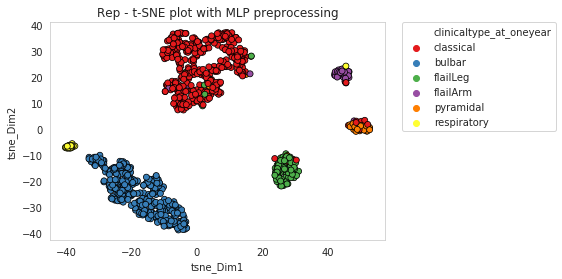

In [ ]:
# Calculate the 2D tSNE and transform it to a Dataframe
res_tsne_2D_rep = sklearnTSNE(n_components=2, perplexity=35, random_state=2).fit_transform(df_nnout_rep)

df_resTSNE_2D_rep = pd.DataFrame(res_tsne_2D_rep, columns=['tsne_Dim1', 'tsne_Dim2'], index=df_1hot_imp_rep.index)

# Plot the 2D t-SNE plot
%matplotlib inline
sns.set_palette('Set1')
sns.scatterplot(x=df_resTSNE_2D_rep.tsne_Dim1, y=df_resTSNE_2D_rep.tsne_Dim2, data=df_raw_rep, hue='clinicaltype_at_oneyear',
               edgecolor='k').set_title('Rep - t-SNE plot with MLP preprocessing')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)





#### t-SNE 3D

In [ ]:
res_tsne_rep = sklearnTSNE(n_components=3, perplexity=20, random_state=42).fit_transform(df_nnout_rep)
df_resTSNE_rep = pd.DataFrame(res_tsne_rep, columns=['tsne_Dim1', 'tsne_Dim2', 'tsne_Dim3'], index=df_1hot_imp_rep.index)

# 3D plot
df_resTSNE_rep_labeled = pd.concat([df_resTSNE_rep, df_raw_rep.clinicaltype_at_oneyear], axis=1, join='inner')

import plotly.express as px
fig = px.scatter_3d(df_resTSNE_rep_labeled, x='tsne_Dim1', y='tsne_Dim2', z='tsne_Dim3',
                    color='clinicaltype_at_oneyear')
fig.show()


#### UMAP

In [ ]:
# Perform UMAP 3D
res_umap3d_columns = ['UMAP_3_1', 'UMAP_3_2', 'UMAP_3_3'] 
res_df_nnout_umap3d_rep = pd.DataFrame(index=df_1hot_imp_rep.index, columns=res_umap3d_columns)

from umap import UMAP
model_umap3d= UMAP(n_neighbors=15,
                 min_dist=1,
                 n_components=3,
                 metric='euclidean')

# Fit model
res_df_nnout_umap3d_rep[['UMAP_3_1', 'UMAP_3_2', 'UMAP_3_3']] = model_umap3d.fit_transform(df_nnout_rep)

# 3D plot
res_df_nnout_umap3d_labeled = pd.concat([res_df_nnout_umap3d_rep, df_raw_rep.clinicaltype_at_oneyear], axis=1, join='inner')

import plotly.express as px
fig = px.scatter_3d(res_df_nnout_umap3d_labeled, x='UMAP_3_1', y='UMAP_3_2', z='UMAP_3_3',
                    color='clinicaltype_at_oneyear')
fig.show()


/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 3 separate connected components using meta-embedding (experimental)



### Export data

In [ ]:
# columns to include with umap
coloring_columns =['clinicaltype_at_oneyear', 'smoker', 'initial_dx_was_PLS', 'c9orf72_status', 
        'mutationPresent', 'mutatedGene', 'mutationAAchange', 'cognitiveStatus1', 
        'cognitiveStatus2', 'cognitiveImpairmentPresent', 'clinicaltype_at_onset', 
        'PEGinserted', 'PEG_daysIntoIllness', 'BIPAP', 'BIPAP_daysIntoIllness', 
        'elEscorial2', 'elEscorial3', 'age_at_onset', 'sex', 'rateOfDeclineALSFRS_per_month']

# export ORG csv NN
df_nnout_color = pd.concat([df_nnout, df_raw[coloring_columns]], axis=1, join='inner')
df_nnout_color.to_csv(r'ALS_NN_org.csv', na_rep='NA')

# export REP csv NN
ddf_nnout_rep_color = pd.concat([df_nnout_rep, df_raw_rep[coloring_columns]], axis=1, join='inner')
ddf_nnout_rep_color.to_csv(r'ALS_NN_rep.csv', na_rep='NA')

# export ORG csv NN + t-SNE
df_resTSNE_color = pd.concat([df_resTSNE, df_raw[coloring_columns]], axis=1, join='inner')
df_resTSNE_color.to_csv(r'ALS_NN_tsne_org.csv', na_rep='NA')

# export REP csv NN + t-SNE
df_resTSNE_rep_color = pd.concat([df_resTSNE_rep, df_raw_rep[coloring_columns]], axis=1, join='inner')
df_resTSNE_rep_color.to_csv(r'ALS_NN_tsne_rep.csv', na_rep='NA')

# export ORG csv NN + UMAP
res_df_nnout_umap3d_color = pd.concat([res_df_nnout_umap3d, df_raw[coloring_columns]], axis=1, join='inner')
res_df_nnout_umap3d_color.to_csv(r'ALS_NN_umap_org.csv', na_rep='NA')

# export REP csv NN + UMAP
res_df_nnout_umap3d_rep_color = pd.concat([res_df_nnout_umap3d_rep, df_raw_rep[coloring_columns]], axis=1, join='inner')
res_df_nnout_umap3d_rep_color.to_csv(r'ALS_NN_umap_rep.csv', na_rep='NA')

## ALS clustering on semi-supervised with GMM

## ALS subtype supervised prediction

In [ ]:
import numpy as np
from  numpy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics 

# dopping columns causing data leakage in predection at time of diagnosis 
training_columns_drop = []

# export df_1hot_imp
df_1hot_imp_color = pd.concat([df_raw['clinicaltype_at_oneyear'], df_1hot_imp], axis=1, join='inner')

X_clinical = df_1hot_imp_color.drop(columns=['clinicaltype_at_oneyear'])
Y_clinical = df_1hot_imp_color['clinicaltype_at_oneyear'].replace(['flailLeg', 'bulbar', 'classical', 'pyramidal', 'flailArm',
       'respiratory'], ['1', '2', '3', '4', '5','6'])

X_train, X_test, Y_train, Y_test = train_test_split(X_clinical, Y_clinical, test_size=0.2, random_state=42)


n_classes = len(Y_test.unique())
fpr = dict()
tpr = dict()
roc_auc = dict()

mean_tpr = dict()
mean_fpr = dict()
mean_auc = dict()

cv = StratifiedKFold(n_splits=5)
lr = LogisticRegression(max_iter=1000)

for k in range(n_classes):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    for train, test in cv.split(X_clinical, Y_clinical):
        preds = lr.fit(X_clinical.iloc[train], Y_clinical.iloc[train]).predict_proba(X_clinical.iloc[test])[:,k]
        label = [1 if int(j) == (k+2) else 0 for j in Y_clinical.iloc[test]] #2,3,4
        fpr, tpr, _ = metrics.roc_curve(label, preds)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        
        i += 1
    
    class_name = 'flailLeg' if k+1==1 else 'bulbar' if k+1==2 else 'classical' if k+1==3 else 'pyramidal' if k+1==4 else 'flailArm' if k+1==5 else 'respiratory' if k+1==6 else 'NA'

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr,
             label=r'{0} mean ROC (AUC = {1:0.2f} $\pm$ {2:0.2f})'.format(class_name, mean_auc, std_auc),
             lw=2, alpha=.8)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)

plt.figure(1, figsize=(9, 5))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.025, 1.025])
plt.ylim([-0.025, 1.025])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
#plt.show()

NameError: ignored